In [1]:
cd ..

/Users/n.barsukov/PycharmProjects/toxic-comments-detector


In [2]:
import sys
import tensorflow as tf
import numpy as np

# local (this repo) imports
from dev import load_cleaned_russian_text_data, evaluate_model, SEED
from wordEmbeddingsLayers import wiki40_russian_embedding_layer

tf.random.set_seed(SEED)

print('Python version:', sys.version)
print('Tensorflow version:', tf.__version__)

Python version: 3.8.9 (default, Apr  3 2021, 01:50:09) 
[Clang 12.0.0 (clang-1200.0.32.29)]
Tensorflow version: 2.4.1


# Build RNN model

In [3]:
X_train, X_test, y_train, y_test = load_cleaned_russian_text_data()

negative_class_amount, pos_class_amount = np.bincount(y_train)

In [4]:
from tensorflow.keras import layers, losses

# подсказываем, что позитивного класса меньше
initial_output_bias = tf.keras.initializers.Constant(
    np.log([pos_class_amount/negative_class_amount])
)
total = (pos_class_amount + negative_class_amount)
class_weight = {
    0: (1 / negative_class_amount)*(total)/2.0,
    1: (1 / pos_class_amount)*(total)/2.0
}

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=3,
    verbose=1,
    restore_best_weights=False
)

model = tf.keras.Sequential([
    layers.Input(shape=[], dtype=tf.string),
    wiki40_russian_embedding_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    layers.Dropout(rate=0.2, seed=SEED),
    tf.keras.layers.Dense(64, activation='relu'),
    layers.Dense(units=1, bias_initializer=initial_output_bias),
    layers.Activation('sigmoid') # то есть в конце мы выдаем уже вероятности
])

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), # from_logits=False, потому что у нас есть финальный 
    optimizer='adam',
    metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Recall(), tf.keras.metrics.Precision()]
)

In [5]:
epochs = 10
history = model.fit(
    x=X_train,
    y=y_train,
    epochs=epochs,
    batch_size=2**7,
    validation_split=0.2, # сколько от тестовой выборки отрезать под валидационную
    callbacks=[early_stopping],
    class_weight=class_weight,
)

Epoch 1/10
73/73 [==============================] - 63s 825ms/step - loss: 0.6205 - binary_accuracy: 0.6488 - recall: 0.6782 - precision: 0.4928 - val_loss: 0.3418 - val_binary_accuracy: 0.8573 - val_recall: 0.7669 - val_precision: 0.7970
Epoch 2/10
73/73 [==============================] - 57s 782ms/step - loss: 0.3133 - binary_accuracy: 0.8788 - recall: 0.8711 - precision: 0.7933 - val_loss: 0.3614 - val_binary_accuracy: 0.8513 - val_recall: 0.9219 - val_precision: 0.7144
Epoch 3/10
73/73 [==============================] - 62s 853ms/step - loss: 0.2426 - binary_accuracy: 0.9089 - recall: 0.9158 - precision: 0.8297 - val_loss: 0.5644 - val_binary_accuracy: 0.7871 - val_recall: 0.9583 - val_precision: 0.6159
Epoch 4/10
73/73 [==============================] - 62s 837ms/step - loss: 0.2160 - binary_accuracy: 0.9149 - recall: 0.9269 - precision: 0.8410 - val_loss: 0.3015 - val_binary_accuracy: 0.8846 - val_recall: 0.9089 - val_precision: 0.7808
Epoch 5/10
73/73 [==========================

# Model evaluation

Accuracy: 90.08%
Recall: 90.67%
Precision: 81.45%
F1-score: 85.81% 

Confusion matrix:
[[1732  197]
 [  89  865]]


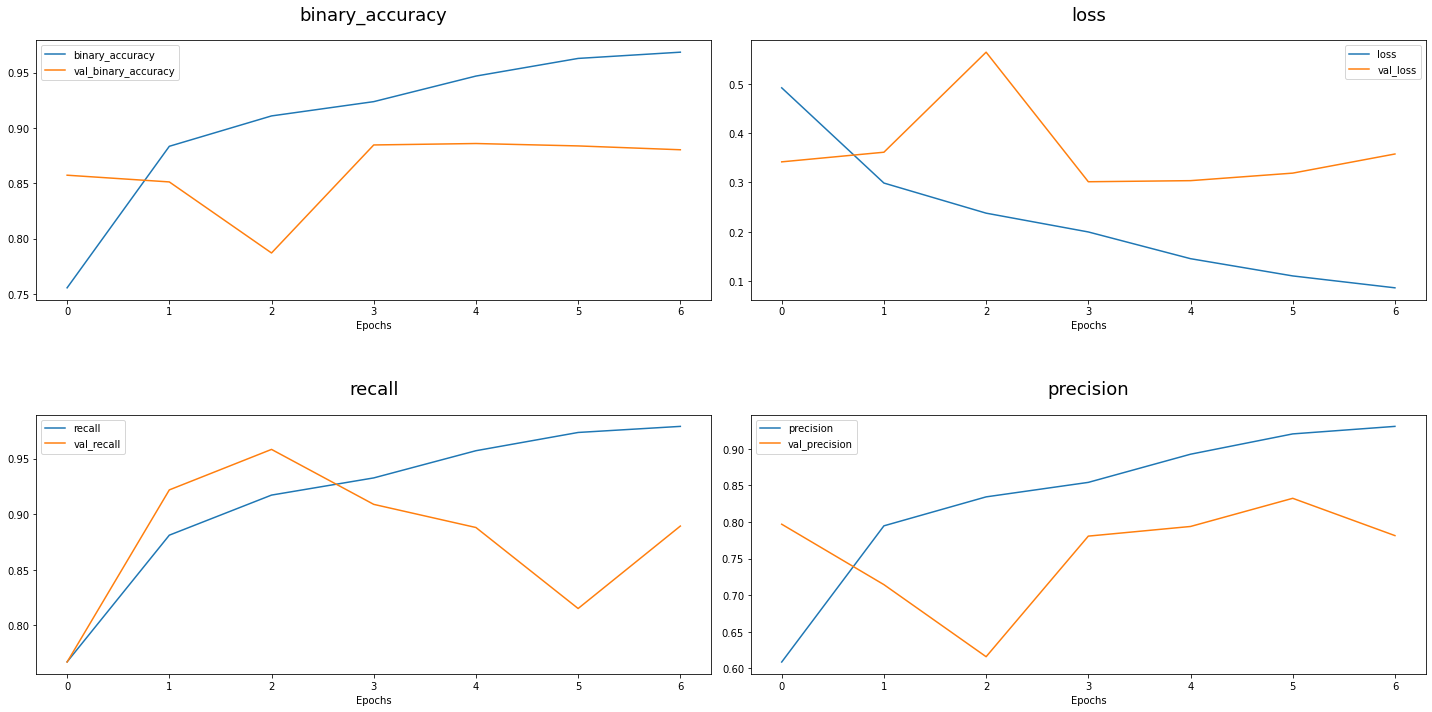

In [6]:
y_test_pred = (model.predict(X_test).flatten() > 0.5) * 1

evaluate_model(y_test, y_test_pred, history)

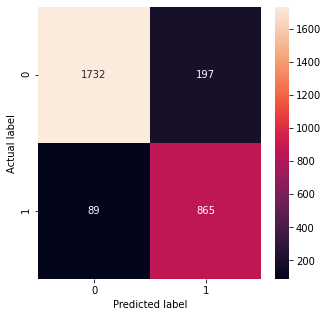

In [7]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def plot_cm(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
#     plt.title('Confusion matrix @{:.2f}'.format(p))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
plot_cm(y_test, y_test_pred)